## Data Prep

In [ ]:
import os
import re

import numpy as np
from rasterio.mask import mask, raster_geometry_mask
import rasterio.plot
from matplotlib import pyplot as plt
import fiona

filename = "AOI_3_Paris_img656"

with fiona.open(f"./AOI_3_Paris_Train/geojson/buildings/buildings_{filename}.geojson") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(f"./AOI_3_Paris_Train/RGB-PanSharpen/RGB-PanSharpen_{filename}.tif") as src:
    img = src.read((3, 2, 1))
    mask_img, transforms = mask(src, shapes, crop=True)
    mask = raster_geometry_mask(src, shapes)[0]
    meta = src.meta

def normalise(im):
    img_max = im.max(axis=(1, 2)).reshape(-1, 1, 1)
    img_min = im.min(axis=(1, 2)).reshape(-1, 1, 1)
    return (((im - img_min) / (img_max - img_min)) * 255).astype(np.ubyte).transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(normalise(img))
axs[1].imshow(normalise(mask_img))

In [ ]:
import wandb

# wandb.init(project="blendersatai", entity="ivs_er")
# wandb.config = {
#     "learning_rate": 0.001,
#     "epochs": 1,
#     "batch_size": 1
# }

sweep_config = {
    "name": "sweep",
    "method": "random",
    "parameters": {
        "learning_rate": {
            "min": 1e-6,
            "max": 1e-4,
            "distribution": "log_uniform_values"
        },
        "momentum": {
            "min": 0.9,
            "max": 0.99,
            "distribution": "inv_log_uniform_values"
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
import torch.nn.functional as F
import torch
import torch.utils.data
from torchvision import transforms
from torch.utils.data import Dataset, random_split

print("CUDA working:", torch.cuda.is_available())
device = torch.device("cuda:0")


class UNetEnlarge:

    def __init__(self, new_dim):
        self.new_dim = new_dim

    def __call__(self, x):
        h_old, w_old = x.shape[1:3]
        new_dim = self.new_dim
        h_new, w_new = new_dim
        if h_old > h_new or w_old > w_new:
            raise ValueError("New dimensions cannot be smaller than old dimensions")
        incr_top, inc_bottom = np.ceil((h_new - h_old) / 2).astype(int), np.floor((h_new - h_old) / 2).astype(int)
        incr_left, incr_right = np.ceil((w_new - w_old) / 2).astype(int), np.floor((w_new - w_old) / 2).astype(int)
        return F.pad(x, (incr_top, inc_bottom, incr_left, incr_right), "reflect")


class SpacenetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".tif")]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        mask_filename = re.sub(r"\.tif$", ".geojson", img_filename)
        mask_filename = re.sub(r"RGB-PanSharpen_", "buildings_", mask_filename)
        
        mask_filepath = os.path.join(self.mask_dir, mask_filename)
        img_filepath = os.path.join(self.img_dir, img_filename)
        
        with fiona.open(mask_filepath) as mask_shape:
            shapes = [feature["geometry"] for feature in mask_shape]
        with rasterio.open(img_filepath) as src:
            img = src.read((3, 2, 1))
            mask = raster_geometry_mask(src, shapes)[0] if len(shapes) > 0 else np.ones(img.shape[1:3]).astype(bool)
            img = normalise(img)
        
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        return img, mask.astype(np.double)

def calculate_unet_output_dim(input_dim, num_layers):
    cur_dim = input_dim
    for _ in range(num_layers):
        cur_dim -= 4
        cur_dim //= 2
    for _ in range(num_layers):
        cur_dim -= 4
        cur_dim *= 2
    cur_dim -= 4
    return cur_dim

def calculate_input_dim(target_dim, num_layers):
    cur_input_dim = target_dim
    output_dim = calculate_unet_output_dim(cur_input_dim, num_layers)
    while output_dim < target_dim:
        cur_input_dim += 1
        output_dim = calculate_unet_output_dim(cur_input_dim, num_layers)
    return cur_input_dim - 1

UNET_LAYERS = 4
IMAGE_DIMS = 650
DOWNSCALE_FACTOR = 2
unet_input_dim = calculate_input_dim(IMAGE_DIMS // DOWNSCALE_FACTOR, UNET_LAYERS)

unet_output_upscale = transforms.Resize(IMAGE_DIMS)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(IMAGE_DIMS // DOWNSCALE_FACTOR),
        UNetEnlarge((523, 523))
    ]
)

train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(IMAGE_DIMS // DOWNSCALE_FACTOR),
        transforms.ColorJitter(brightness=0.3, contrast=0.7, saturation=0.7, hue=0.05),
        UNetEnlarge((523, 523))
    ]
)

train_test_split = 0.9
dataset = SpacenetDataset(
    "./AOI_3_Paris_Train/RGB-PanSharpen",
    "./AOI_3_Paris_Train/geojson/buildings",
    transform=transform
)
split_index = int(len(dataset) * train_test_split)
train_dataset, test_dataset = random_split(dataset, [split_index, len(dataset) - split_index])
train_dataset.dataset.transform = train_transforms

# def trainset_reduce_empty(config, dset):
#     EMPTY_MASKS_REDUCTION = config["empty_dropout"]
#     all_empty_imgs = [i for i, (img, mask) in enumerate(dset) if np.all(mask == 1.0)]
#     empty_imgs_select = np.random.choice(all_empty_imgs, size=int(len(all_empty_imgs) * EMPTY_MASKS_REDUCTION), replace=False)
#     train_dataset_no_empty = torch.utils.data.Subset(dset, [i for i in range(len(dset)) if i not in all_empty_imgs])
#     train_dataset_empty = torch.utils.data.Subset(dset, empty_imgs_select)
#     return torch.utils.data.ConcatDataset([train_dataset_no_empty, train_dataset_empty])

test_size = len(test_dataset)
test_dataset, val_dataset = random_split(test_dataset, [test_size // 2, test_size - test_size // 2])
print("Data shape:", train_dataset[0][0].shape, "Mask shape:", train_dataset[0][1].shape)
"Training data:", len(train_dataset), "Testing data:", len(test_dataset), "Validation data:", len(val_dataset)

In [ ]:
from random import randrange

enlarge_transform = UNetEnlarge(new_dim=(834, 834))
fig, axs = plt.subplots(5, 1, figsize=(30, 30))
# enlarged = enlarge_transform(sample)
# print(sample.shape, enlarged.shape)
for i in range(5):
    axs[i].imshow(train_dataset[randrange(0, len(train_dataset))][0].permute(1, 2, 0))

In [ ]:
BATCH_SIZE = 5

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

## Test Model
Exclusively for dataloader and CUDA testing.

In [ ]:
from torch import nn


class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 11, padding=5)
        self.conv3 = nn.Conv2d(16, 1, 5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(dim=1)

## UNet

In [ ]:
def crop_masks(masks, dims):
    # dims smaller than masks
    if masks.shape[-2] < dims[0] or masks.shape[-1] < dims[1]:
        raise ValueError("Dims must be smaller than masks")
    is_batch = False
    if len(masks.shape) == 4:
        # batch, channels, y, x
        is_batch = True
    h_old, w_old = masks.shape[-2:]
    h_new, w_new = dims
    h_diff = h_old - h_new
    w_diff = w_old - w_new
    top, bottom = h_diff // 2, h_diff - h_diff // 2
    left, right = w_diff // 2, w_diff - w_diff // 2
    if not is_batch:
        return masks[:, top: h_old - bottom, left: w_old - right]
    return masks[:, :, top: h_old - bottom, left: w_old - right]

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layers = []
        decoder_layers = []

        # channels = [3, 64, 128, 256, 512, 1024]
        channels = [3]
        for i in range(UNET_LAYERS + 1):
            channels.append(2 ** (i + 6))
        for prev_c, c in zip(channels[:-1], channels[1:-1]):
            encoder_layers.append(
                nn.Sequential(
                    nn.Conv2d(prev_c, c, 3),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(c, c, 3),
                    nn.ReLU(inplace=True),
                )
            )
            encoder_layers.append(
                nn.MaxPool2d(kernel_size=2)
            )

        self.bottom_layer = nn.Sequential(
            nn.Conv2d(channels[-2], channels[-1], 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels[-1], channels[-1], 3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(channels[-1], channels[-2], kernel_size=2, stride=2)
        )

        for i in reversed(range(3, len(channels))):
            layer = nn.Sequential(
                nn.Conv2d(channels[i], channels[i - 1], 3),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels[i - 1], channels[i - 1], 3),
                nn.ReLU(inplace=True),
            )
            layer.append(nn.ConvTranspose2d(channels[i - 1], channels[i - 2], kernel_size=2, stride=2))
            decoder_layers.append(layer)
        decoder_layers.append(nn.Sequential(
            nn.Conv2d(channels[2], channels[1], 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels[1], channels[1], 3),
            nn.ReLU(inplace=True),
        ))

        self.final_layer = nn.Sequential(
            nn.Conv2d(channels[1], 1, 1)
        )
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

        self.upscale = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2)

    def encode(self, x):
        xs = []
        layers = self.encoder.children()
        for convs in layers:
            maxpool = next(layers)
            x = convs(x)
            xs.append(x)
            x = maxpool(x)
        return x, xs

    @staticmethod
    def concat_layer(z, x):
        # z is smaller one, x is larger
        x_crop = crop_masks(x, z.shape[-2:])
        return torch.cat((z, x_crop), dim=1)

    def decode(self, z, xs):
        z = self.bottom_layer(z)
        for i, l in enumerate(self.decoder.children()):
            z = self.concat_layer(z, xs[-(i + 1)])
            z = l(z)
        return self.final_layer(z)

    def forward(self, x):
        z, xs = self.encode(x)
        m = self.decode(z, xs)
        return self.upscale(m)

In [ ]:
from torch import optim
from torchinfo import summary

# net = UNet().to(device)
# summary(net)

In [ ]:
RUN_TRAINING = False

EPOCHS = 50
criterion = nn.BCEWithLogitsLoss()

loss_history = []
val_loss_history = []

def make_model(config):
    mdl = UNet().to(device)
    optimizer = optim.RMSprop(mdl.parameters(), lr=config["learning_rate"], weight_decay=1e-8, momentum=config["momentum"])
    return mdl, optimizer

def val_loss(mdl, val_loader):
    running_loss = 0.0
    mdl.eval()
    with torch.no_grad():
        for i, d in enumerate(val_loader):
            inputs, masks = d
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = mdl(inputs).squeeze(dim=1)
            masks = crop_masks(masks, outputs.shape[1:3])
            loss = criterion(outputs, masks)

            running_loss += loss.item()
    return running_loss

def dice_loss(inputs, targets, eps=1):
    assert inputs.shape == targets.shape
    inputs = inputs.reshape(-1)
    targets = targets.reshape(-1)
    intersection = (inputs * targets).sum()
    dice = (2 * intersection + eps) / (inputs.sum() + targets.sum() + eps)
    return 1 - dice

def train(mdl, optim, tloader):
    mdl.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i, (inputs, masks) in enumerate(tloader):
            inputs = inputs.to(device)
            masks = masks.to(device)

            optim.zero_grad()
            outputs = mdl(inputs).squeeze(dim=1)
            masks = crop_masks(masks, outputs.shape[1:3])
            loss = criterion(outputs, masks) + dice_loss(F.softmax(outputs, dim=1), masks)
            loss.backward()
            optim.step()

            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                v_loss = val_loss(mdl, valloader)
                mdl.train()
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f} val_loss: {v_loss}')
                loss_history.append(loss)
                val_loss_history.append(v_loss)
                # wandb.log({"loss": running_loss, "val_loss": v_loss})
                running_loss = 0.0

            if i == 200:
                break

def wandb_train():
    with wandb.init() as run:
        config = wandb.config
        mdl, optim = make_model(config)
        train(mdl, optim, trainloader)

# wandb.agent(sweep_id, function=wandb_train, count=20)
# wandb.finish()

if RUN_TRAINING:
    mdl = UNet().to(device)
    train(mdl, optim.RMSprop(mdl.parameters(), lr=2e-5, weight_decay=1e-8, momentum=0.93), trainloader)
    torch.save(mdl.state_dict(), "./model.pt")
else:
    mdl = UNet().to(device)
    mdl.load_state_dict(torch.load("./model.pt"))
mdl.eval()

In [ ]:
plt.plot([x.item() for x in loss_history][10:])
plt.plot(val_loss_history[10:])

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()
summary(mdl, (1, 3, 325, 325))

In [ ]:
from torch.utils.data import RandomSampler

def visualise_test(mdl):
    mdl.eval()
    num_vis = 10

    r = RandomSampler(test_dataset, num_samples=num_vis)
    fig, axs = plt.subplots(num_vis, 2, figsize=(18, 70))
    for i, d_idx in enumerate(r):
        test_in, test_gt = test_dataset[d_idx]
        test_in = test_in.to(device)

        with torch.no_grad():
            outputs = mdl(test_in.unsqueeze(dim=0)).squeeze(dim=0)
        test_gt = crop_masks(np.expand_dims(test_gt, axis=0), outputs.shape[-2:])
        test_net = torch.sigmoid(outputs)[0].cpu()

        test_in = crop_masks(test_in, (325, 325))
        test_in = transforms.Resize((650, 650))(test_in)
        test_in = crop_masks(test_in, outputs.shape[-2:])

        test_in = test_in.cpu()
        test_in_clone = test_in.clone()
        test_in[0][test_gt == 0.0] += 0.3
        test_in[0][test_in[0] > 1.0] = 1.0
        test_in_clone[0][test_net < 0.5] += 0.3
        test_in_clone[0][test_in_clone[0] > 1.0] = 1.0
        axs[i, 0].imshow(test_in.permute(1, 2, 0))
        # axs[i, 0].imshow(test_gt)
        axs[i, 1].imshow(test_in_clone.permute(1, 2, 0))
        # axs[i, 1].imshow(outputs.cpu()[0])

visualise_test(mdl)

In [ ]:
def single_example(filepath):
    img = plt.imread(filepath)
    img = img[..., :3] - 0.3
    img[img < 0.0] = 0.0
    img = img.transpose(2, 0, 1)
    img = crop_masks(img, (650, 650))
    img = img.transpose(1, 2, 0)

    net_input = transform(img).to(device).unsqueeze(dim=0)
    img = img.transpose(2, 0, 1)
    with torch.no_grad():
        out = torch.sigmoid(mdl(net_input).squeeze(dim=0))[0].cpu()
    img = crop_masks(img, out.shape[-2:])
    img_clone = img.copy()
    img_clone[0][out < 0.8] += 0.3
    img_clone[0][img_clone[0] > 1.0] = 1.0

    fig, axs = plt.subplots(1, 2, figsize=(18, 70))
    axs[0].imshow(img.transpose(1, 2, 0))
    axs[1].imshow(img_clone.transpose(1, 2, 0))

single_example("/home/ivan/Pictures/hampstead.png")

In [11]:
import gc

gc.collect()
torch.cuda.empty_cache()
summary(mdl, (1, 3, 325, 325))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Sequential: 1                          --                        --
│    └─Sequential: 2-1                   [1, 64, 321, 321]         --
│    │    └─Conv2d: 3-1                  [1, 64, 323, 323]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 323, 323]         --
│    │    └─Conv2d: 3-3                  [1, 64, 321, 321]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 321, 321]         --
│    └─MaxPool2d: 2-2                    [1, 64, 160, 160]         --
│    └─Sequential: 2-3                   [1, 128, 156, 156]        --
│    │    └─Conv2d: 3-5                  [1, 128, 158, 158]        73,856
│    │    └─ReLU: 3-6                    [1, 128, 158, 158]        --
│    │    └─Conv2d: 3-7                  [1, 128, 156, 156]        147,584
│    │    └─ReLU: 3-8                    [1, 128, 156, 156]        --

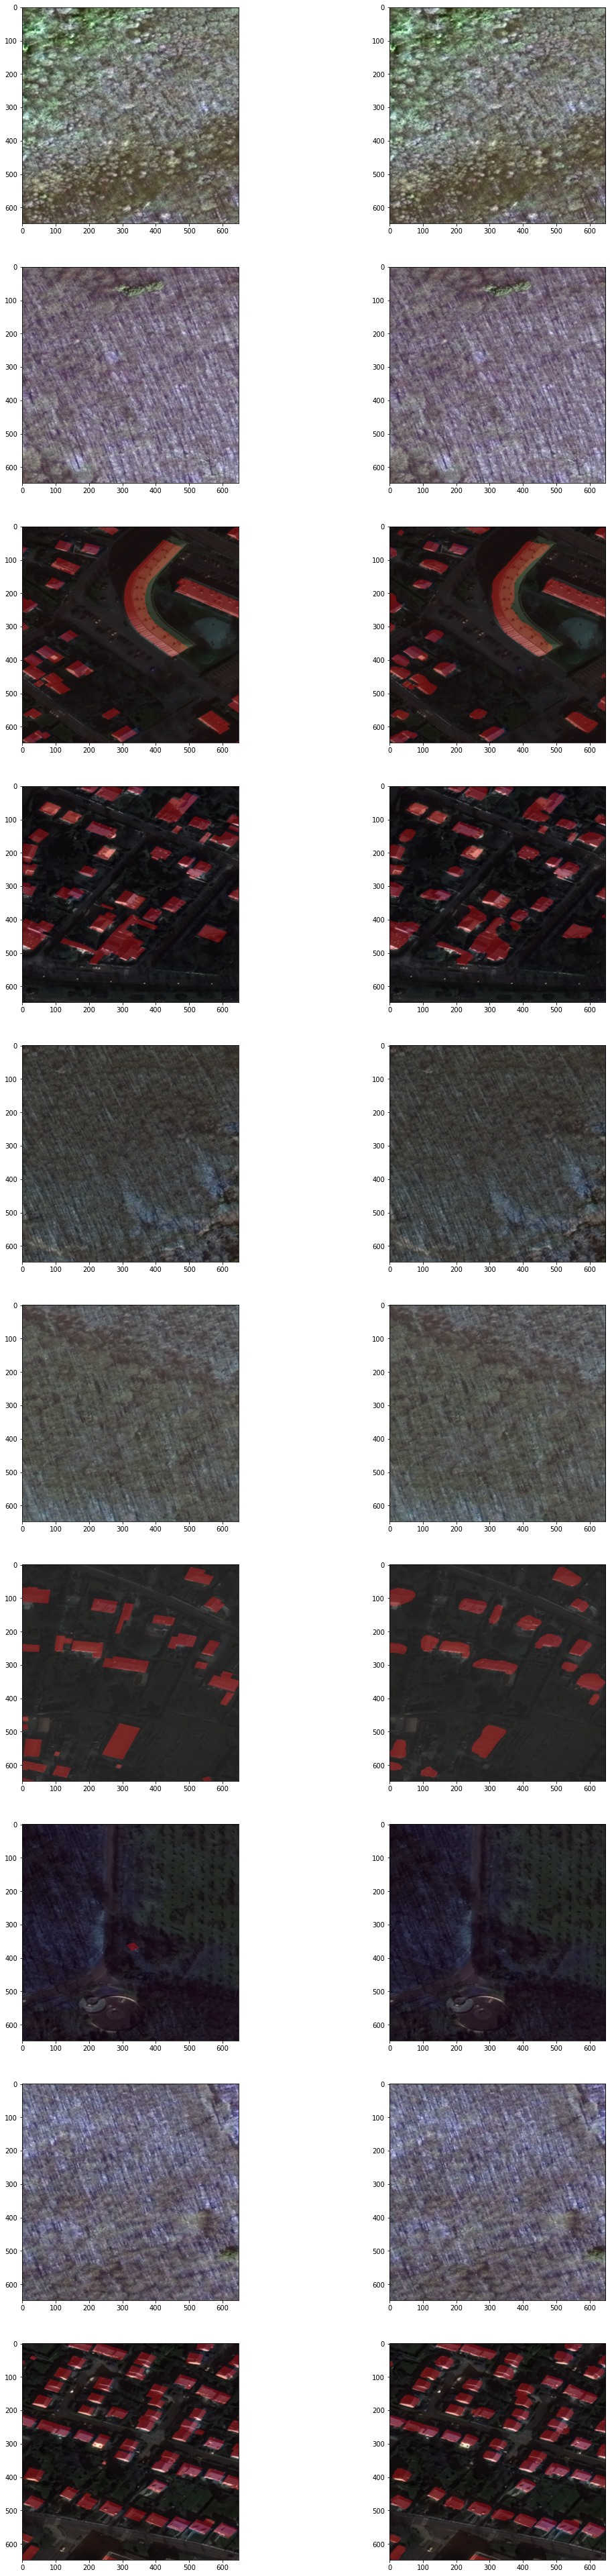

In [12]:
from torch.utils.data import RandomSampler

def visualise_test(mdl):
    mdl.eval()
    num_vis = 10

    r = RandomSampler(test_dataset, num_samples=num_vis)
    fig, axs = plt.subplots(num_vis, 2, figsize=(18, 70))
    for i, d_idx in enumerate(r):
        test_in, test_gt = test_dataset[d_idx]
        test_in = test_in.to(device)

        with torch.no_grad():
            outputs = mdl(test_in.unsqueeze(dim=0)).squeeze(dim=0)
        test_gt = crop_masks(np.expand_dims(test_gt, axis=0), outputs.shape[-2:])
        test_net = torch.sigmoid(outputs)[0].cpu()

        test_in = crop_masks(test_in, (325, 325))
        test_in = transforms.Resize((650, 650))(test_in)
        test_in = crop_masks(test_in, outputs.shape[-2:])

        test_in = test_in.cpu()
        test_in_clone = test_in.clone()
        test_in[0][test_gt == 0.0] += 0.3
        test_in[0][test_in[0] > 1.0] = 1.0
        test_in_clone[0][test_net < 0.5] += 0.3
        test_in_clone[0][test_in_clone[0] > 1.0] = 1.0
        axs[i, 0].imshow(test_in.permute(1, 2, 0))
        # axs[i, 0].imshow(test_gt)
        axs[i, 1].imshow(test_in_clone.permute(1, 2, 0))
        # axs[i, 1].imshow(outputs.cpu()[0])

visualise_test(mdl)

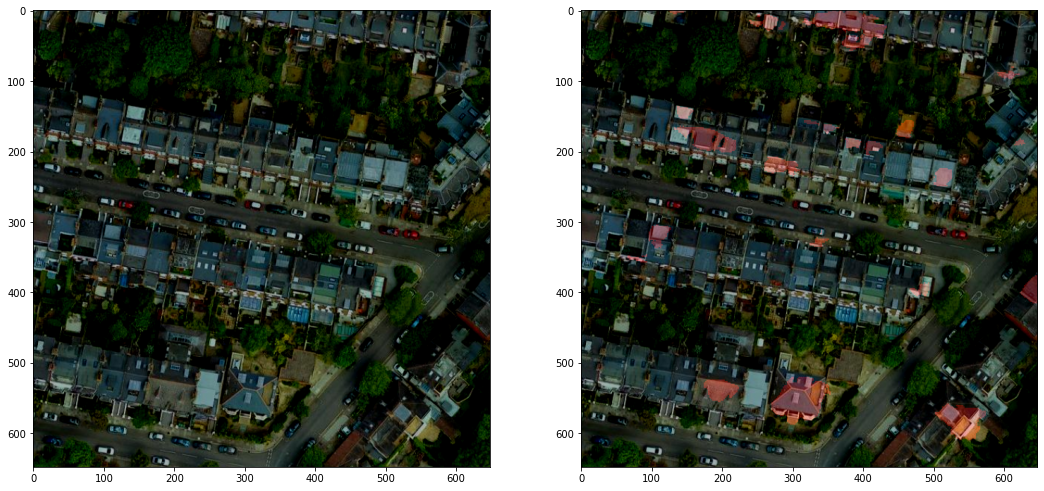

In [57]:
def single_example(filepath):
    img = plt.imread(filepath)
    img = img[..., :3] - 0.3
    img[img < 0.0] = 0.0
    img = img.transpose(2, 0, 1)
    img = crop_masks(img, (650, 650))
    img = img.transpose(1, 2, 0)

    net_input = transform(img).to(device).unsqueeze(dim=0)
    img = img.transpose(2, 0, 1)
    with torch.no_grad():
        out = torch.sigmoid(mdl(net_input).squeeze(dim=0))[0].cpu()
    img = crop_masks(img, out.shape[-2:])
    img_clone = img.copy()
    img_clone[0][out < 0.8] += 0.3
    img_clone[0][img_clone[0] > 1.0] = 1.0

    fig, axs = plt.subplots(1, 2, figsize=(18, 70))
    axs[0].imshow(img.transpose(1, 2, 0))
    axs[1].imshow(img_clone.transpose(1, 2, 0))

single_example("/home/ivan/Pictures/hampstead.png")